# Analysis of M66 (NGC 3627) with JWST

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D, MedianBackground
from photutils.utils import calc_total_error

from perform_photometry import find_objects

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

In [9]:
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

## Notes

**Photometry**: <br>
- links for [conversion](https://jwst-docs.stsci.edu/jwst-near-infrared-camera#gsc.tab=0) and [filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0).
- Create a region file when I take photometry.
- In `find_objects()`, add conversion rates on the basis of the filters used. Also add the feature to provide data either as a path or the data itself. 
- Automate the whole photometry process'
- short wavelength pix conversion = 0.031''/pixel
- long wavelength pix conversion = 0.063''/pixel

**Infrared Object identification**
- I found SNRs in M66 which I should take a look at while doing the infrared object identifcation. They can be found on the wikipedia page for M66. 

**JWST**
- Found encircled energy fractions from [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-Encircledenergy).

**Misc**
- Always keep in mind that coordinates are flipped in a fits image
- Learn how to import functions

## Querying JWST Data

In [ ]:
%%time

filters = ["F150W", "F200W", "F150W", "F277W", "F444W"
           "F300M", "F335M", "F360M",
           "F187N", "F212N"]
proposal_id = [2107, 4793]
print("Finding observations for JWST images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="JWST",
                                        filters=filters, proposal_id=proposal_id,
                                        instrument_name="NIRCAM/IMAGE")
print("Done")

Finding observations for JWST images...


In [5]:
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str7,str12,str4,str5,str8,str8,str84,str36,float64,float64,str5,str15,int64,float64,float64,float64,float64,float64,str105,float64,str4,str2,int64,str115,str62,str63,str6,bool,float64,str9,str9,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f150w,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7612082816,60665.776121145835,858.9439999999997,1331.0,1668.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869366 12.963631618 170.03292137 12.978889968 170.048625314 13.017934287 170.088578625 13.002673538,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.fits,PUBLIC,False,nan,234389769,793836430,793836430,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F360M,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f360m,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.60078729606,59957.65987877315,858.9439999999996,3427.0,3814.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064025948 12.942315942 170.02645268 12.956365371 170.052701715 13.023033291 170.090283579 13.008980093,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.fits,PUBLIC,False,nan,109508031,747060856,747060856,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F200W,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f200w,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.600786555326,59957.68150171296,2405.0399999999995,1755.0,2226.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064228842 12.942098631 170.025897491 12.956670458 170.052784974 13.023840005 170.09112511 13.009264239,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.fits,PUBLIC,False,nan,109507984,747060759,747060759,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F335M,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f335m,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.70665361806,60665.730638229164,1631.992,3177.0,3538.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072667126 12.963856686 170.033312403 12.978642692 170.048534577 13.017118324 170.08789449 13.002330028,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.fits,PUBLIC,False,nan,234389745,793836338,793836338,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F212N,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f212n,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7343661875,60665.75835078704,1631.992,2109.0,2134.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869214 12.963632641 170.032918963 12.978891781 170.048622441 13.017935126 170.088578008 13.002673587,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.fits,P

In [6]:
# The code is downloading many extra files that are not needed. 
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)

data_prod = ['I2D']       # other options are ['FLT','DRC','DRZ']
data_type = ['CALJWST']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")

 This may take several minutes... 



obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str9,str6,int64,str5
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_stream.fits,408960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_uncal.fits,420480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq1_2023013152509_cal.fits,1284480,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_stream.fits,37440,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_uncal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_uncal.fits,48960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_cal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq2_2023013152511_cal.fits,106560,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_stream.fits,4731840,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_uncal.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_uncal.fits,5964480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153258_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153258_stream.fits,1589760,109507984,PUBLIC,1,F200W


Since the above code is downloading additional files that are not required, I am manually downloading data from this [link](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for M66. 

The filters that I am using are: 360m, 335m, 300m, 200w

# Photometry

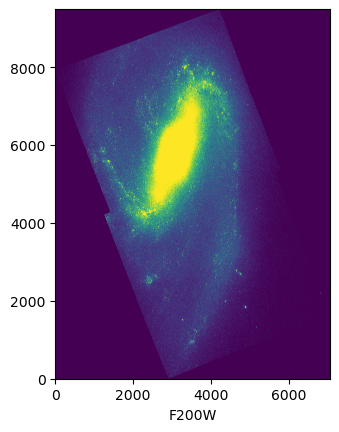

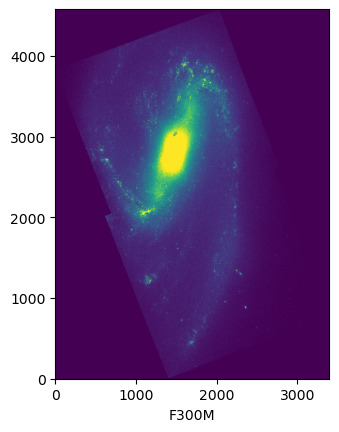

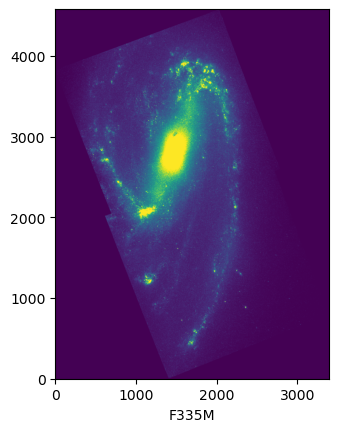

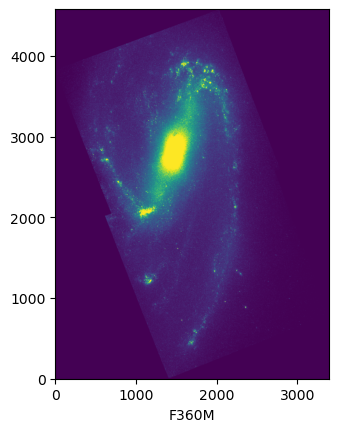

In [11]:
# just to see how the images look like
images = {
          "F200W" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits",
          "F300M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits",
          "F335M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits",
          "F360M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"
}

for filter in images:
    hdu = fits.open(images[filter])
    data = hdu['sci'].data
    plt.imshow(data, origin='lower', vmin=0, vmax=10)
    plt.xlabel(filter)
    plt.show()

In [60]:
def find_objects(data, fwhm, threshold=None, sigma=5, conversion=0.031, radius=5, cmap='gray_r', vmin=0, vmax=0.3, std_multiple=5, aperture_color='limegreen', plot=True):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma)
    if threshold:
        daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=threshold)
        objects = daofind(data)
        
    else:
        daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=std_multiple*std)
        objects = daofind(data)

    print("Found", len(objects), "objects.")
    positions = np.transpose((objects["xcentroid"], objects["ycentroid"]))

    # Create apertures around sources
    if plot:
        apertures = CircularAperture(positions, r=radius)
        plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        apertures.plot(color=aperture_color)
        plt.show()
    
    return positions

## F200W

In [6]:
data = fits.getdata(f200w)
data = data[3260:3420, 3080:3240]
fwhm = 0.17
conversion = 0.031
mean, median, std = sigma_clipped_stats(data, sigma=5)
print(f"std is {std} and fwhm is ", fwhm/conversion)
daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=3*std)
objects = daofind(data)
positions = np.transpose((objects["xcentroid"], objects["ycentroid"]))
# # Create apertures around sources
# apertures = CircularAperture(positions, r=5)
# plt.imshow(data, cmap='gray_r', vmin=0, vmax=10, origin='lower')
# apertures.plot(color='limegreen')
# plt.show()
objects

std is 0.7309746146202087 and fwhm is  5.483870967741936


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64
1,27.253222575522877,1.9157075260439422,0.51694783360863,-0.32038325,-0.9520089454994645,49,2.3636944,59.30283,-4.4326887,-0.047337813546789
2,52.99925492245154,1.4887964280277162,0.7091126948775881,-0.08543224,-0.6455881312122578,49,4.2535625,67.86872,-4.579174,-0.7533765814577488
3,106.75134652547038,1.2223093941180563,0.6830269260061181,-0.2130557,-0.34603980402569867,49,7.519151,101.757484,-5.018916,-1.501831295572167
4,115.46499602279773,2.294088308909564,0.6476417188556781,-0.7262285,-0.3084582618004365,49,3.2943945,74.374695,-4.678563,-0.2992077758914108
5,147.2164036913612,1.8909588177440024,0.6133269269255643,-0.86853665,-0.5972594928367175,49,3.6015036,75.58134,-4.6960363,-0.545956017527328
6,1.4497417728658584,2.4094365995746116,0.4528470791829628,-0.606665,0.5323330670554081,49,1.9900506,43.410225,-4.0939803,-0.11526963453279065
7,46.63978694931053,4.747763739506235,0.36993242768902046,0.12764898,0.30363235555757223,49,2.6036656,84.883675,-4.8220606,-0.029563492452264962
8,62.909700624509426,2.0482564511348307,0.6676776533638016,-0.0060255243,-0.12693112389040997,49,10.08234,125.37752,-5.245549,-1.8772716706767258
9,73.28694066578281,2.436015517908699,0.42317618756835695,0.1597677,-0.3095452895568953,49,3.3093846,88.17994,-4.863425,-0.5569208227771791


I quite like the configuration above

In [7]:
positions

array([[ 27.25322258,   1.91570753],
       [ 52.99925492,   1.48879643],
       [106.75134653,   1.22230939],
       [115.46499602,   2.29408831],
       [147.21640369,   1.89095882],
       [  1.44974177,   2.4094366 ],
       [ 46.63978695,   4.74776374],
       [ 62.90970062,   2.04825645],
       [ 73.28694067,   2.43601552],
       [ 86.19935271,   4.73717081],
       [124.41212224,   4.18894608],
       [114.83763236,   4.68109716],
       [ 41.71527419,   6.32276517],
       [ 46.45204583,   7.18199536],
       [ 90.02241045,   7.23737993],
       [  1.27456432,   7.72776833],
       [ 78.24414613,   8.42046783],
       [ 19.84273355,  10.19384265],
       [ 33.97323689,  10.78811585],
       [ 62.77253266,  11.91986024],
       [103.30318292,  11.70903028],
       [  3.07445529,  12.7390929 ],
       [ 12.70209571,  12.67596913],
       [ 45.03397915,  13.33721815],
       [ 83.10605871,  13.41127036],
       [ 49.74835207,  15.36394024],
       [ 31.69479362,  16.01010102],
 

Found 144936 objects.


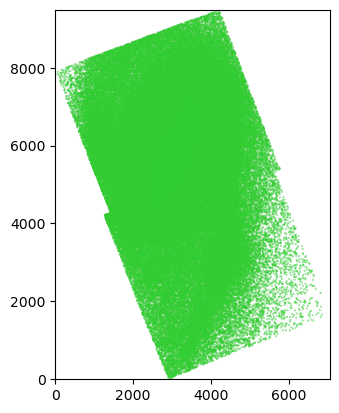

CPU times: user 1min 55s, sys: 5.25 s, total: 2min
Wall time: 1min 58s


In [63]:
%%time
data = fits.getdata(f200w)
objects = find_objects(data, fwhm=0.17, vmax=10, std_multiple=3)

In [97]:
cd(jwstdir)

In [99]:
%%time
# Taking aperture photometry on a range of apertures from 1-30 pix
ap_rads = [i for i in range(1,31)]
apertures_full = [CircularAperture(objects, r=r) for r in ap_rads]

# substract background from the data
sigma_clip = SigmaClip(sigma=5)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), 
                   sigma_clip=sigma_clip,
                   bkg_estimator=bkg_estimator)
data_sub = data - bkg.background
hdu = fits.open(f200w)
phot_full = aperture_photometry(data_sub, apertures_full, 
    		            error=calc_total_error(data, data-data_sub,
    				  effective_gain=hdu[1].header["XPOSURE"]))

phot_full.write("photometry_jwst_M66_f200w.ecsv")

CPU times: user 1min 33s, sys: 6.33 s, total: 1min 40s
Wall time: 1min 40s


Found 249 objects.


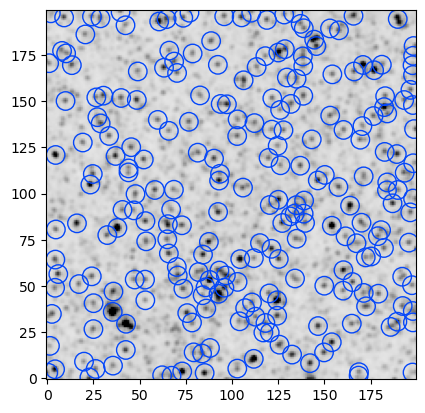

Time for the run: 0.005183116594950358 minutes


In [3]:
from perform_photometry import find_objects

data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
objects = find_objects(data, fwhm=0.14, vmax=10)

# Testing

In [22]:
data = pd.read_csv("/Users/undergradstudent/Research/XRB-Analysis/Notebooks/Encircled_Energy_SW_ETCv2.txt")

In [23]:
data

,aper_radius F070W F090W F115W F140M F150W2 F150W F162M F164N F182M F187N F200W F210M F212N
0,0.010 0.221 0.175 0.137 0.099 0.090 0.094 0.07...
1,0.020 0.423 0.414 0.376 0.300 0.277 0.279 0.24...
2,0.030 0.493 0.537 0.559 0.496 0.469 0.456 0.43...
3,0.040 0.553 0.565 0.616 0.606 0.591 0.562 0.56...
4,0.050 0.614 0.613 0.629 0.640 0.639 0.616 0.63...
5,0.060 0.658 0.674 0.664 0.649 0.652 0.653 0.65...
6,0.070 0.686 0.709 0.710 0.668 0.664 0.678 0.66...
7,0.080 0.702 0.732 0.747 0.711 0.697 0.704 0.67...
8,0.090 0.717 0.746 0.766 0.752 0.736 0.727 0.71...
9,0.100 0.735 0.755 0.776 0.780 0.771 0.750 0.75...


In [83]:
import os
import pandas as pd

cd = os.chdir

cd("/Users/undergradstudent/Downloads/XRBID/XRBID/")
ACS_EEFs = pd.read_csv("ACS_WFC_EEFs.txt")
WFC3_EEFs = pd.read_csv("WFC3_UVIS1_EEFs.frame") 
ACS_EEFs

,Filter,1,2,3,4,5,6,7,8,9,10,20,40
0,F435W,0.330,0.665,0.793,0.838,0.862,0.876,0.887,0.895,0.901,0.907,0.941,0.979
1,F475W,0.328,0.670,0.794,0.841,0.867,0.881,0.891,0.900,0.906,0.911,0.943,0.978
2,F502N,0.327,0.671,0.795,0.841,0.867,0.883,0.893,0.901,0.908,0.913,0.944,0.977
3,F555W,0.328,0.670,0.796,0.840,0.867,0.883,0.894,0.902,0.909,0.914,0.945,0.976
4,F550M,0.329,0.669,0.796,0.840,0.866,0.883,0.894,0.902,0.909,0.914,0.945,0.975
5,F606W,0.331,0.665,0.796,0.839,0.865,0.883,0.895,0.903,0.910,0.915,0.946,0.974
6,F625W,0.332,0.660,0.797,0.839,0.864,0.883,0.895,0.903,0.910,0.915,0.947,0.973
7,F658N,0.333,0.656,0.797,0.839,0.863,0.883,0.896,0.904,0.910,0.916,0.948,0.973
8,F660N,0.333,0.655,0.797,0.839,0.863,0.883,0.896,0.904,0.910,0.916,0.948,0.972
9,F775W,0.327,0.626,0.783,0.836,0.859,0.877,0.894,0.903,0.910,0.916,0.949,0.972


In [84]:
instrument = 'acs'
filter = "F275W"
EEF = WFC3_EEFs[WFC3_EEFs['Filter']==filter.upper()].reset_index()['20.75'][0]

print(EEF)

0.9265


In [85]:
filter = 'F435W'
EEF = ACS_EEFs[ACS_EEFs['Filter']==filter.upper()].reset_index()['20'][0]
print(EEF)

0.941


In [100]:
ACS_EEFs[ACS_EEFs['Filter']==filter.upper()].reset_index()['20'][0]

np.float64(0.941)

In [127]:
display(ACS_EEFs.head())
display(short_EEFs.head())

,Filter,1,2,3,4,5,6,7,8,9,10,20,40
0,F435W,0.330,0.665,0.793,0.838,0.862,0.876,0.887,0.895,0.901,0.907,0.941,0.979
1,F475W,0.328,0.670,0.794,0.841,0.867,0.881,0.891,0.900,0.906,0.911,0.943,0.978
2,F502N,0.327,0.671,0.795,0.841,0.867,0.883,0.893,0.901,0.908,0.913,0.944,0.977
3,F555W,0.328,0.670,0.796,0.840,0.867,0.883,0.894,0.902,0.909,0.914,0.945,0.976
4,F550M,0.329,0.669,0.796,0.840,0.866,0.883,0.894,0.902,0.909,0.914,0.945,0.975


,aper_radius,F070W,F090W,F115W,F140M,F150W2,F150W,F162M,F164N,F182M,F187N,F200W,F210M,F212N
0,0.01,0.022,0.175,0.137,0.099,0.090,0.094,0.077,0.075,0.062,0.060,0.055,0.049,0.047
1,0.02,0.423,0.414,0.376,0.300,0.277,0.279,0.246,0.241,0.204,0.198,0.184,0.165,0.161
2,0.03,0.493,0.537,0.559,0.496,0.469,0.456,0.431,0.425,0.371,0.362,0.339,0.309,0.302
3,0.04,0.553,0.565,0.616,0.606,0.591,0.562,0.566,0.562,0.514,0.505,0.480,0.449,0.441
4,0.05,0.614,0.613,0.629,0.640,0.639,0.616,0.634,0.633,0.607,0.602,0.582,0.558,0.552


In [130]:
ACS_EEFs[ACS_EEFs['Filter']==filter.upper()]

,Filter,1,2,3,4,5,6,7,8,9,10,20,40
0,F435W,0.33,0.665,0.793,0.838,0.862,0.876,0.887,0.895,0.901,0.907,0.941,0.979


In [143]:
short_EEFs.at[0, "F070W"]

np.float64(0.022)

In [65]:
long_filter = ["F070W", "F090W", "F115W", "F140M",
                    "F150W2", "F150W", "F162M", "F164N",
                    "F182M", "F187N", "F200W", "F210M",
                    "F212N", "F250M", "F277W", "F300M",
                    "F322W2", "F323N", "F335M", "F356W",
                    "F360M", "F405N", "F410M", "F430M",
                    "F444W", "F460M", "F466N", "F470N"
                    "F480M"]

short_filter = ["F070W", "F090W", "F115W", "F140M",
                "F150W2", "F150W", "F162M", "F164N",
                "F182M", "F187N", "F200W", "F210M",
                "F212N"]

#

# Testing if my code works 

In [146]:
# Load data sets
short_EEFs = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Notebooks/Encircled_Energy_SW_ETCv2.csv')
long_EEFs = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Notebooks/Encircled_Energy_LW_ETCv2.csv')
long_filter = ["F070W", "F090W", "F115W", "F140M",
                    "F150W2", "F150W", "F162M", "F164N",
                    "F182M", "F187N", "F200W", "F210M",
                    "F212N", "F250M", "F277W", "F300M",
                    "F322W2", "F323N", "F335M", "F356W",
                    "F360M", "F405N", "F410M", "F430M",
                    "F444W", "F460M", "F466N", "F470N"
                    "F480M"]
short_filter = ["F070W", "F090W", "F115W", "F140M",
                "F150W2", "F150W", "F162M", "F164N",
                "F182M", "F187N", "F200W", "F210M",
                "F212N"]

In [200]:
def my_EEF(filter):
    if filter in short_filter:
        return long_EEFs.at[14, filter]
    if filter in long_filter:
        return long_EEFs.at[19, filter]
    

In [159]:
filter = 'F212N'
EEF1 = my_EEF(filter)
print(EEF1)

filter1 = "F090W"
EEF2 = my_EEF(filter1)
print(EEF2)

0.921
0.948


In [156]:
display(long_EEFs)
display(short_EEFs)

0.031 * 20, 0.063 * 20

,aper_radius,F070W,F090W,F115W,F140M,F150W,F150W.1,F162M,F164N,F182M,...,F356W,F360M,F405N,F410M,F430M,F444W,F460M,F466N,F470N,F480M
0,0.01,0.221,0.175,0.137,0.099,0.090,0.094,0.077,0.075,0.062,...,0.030,0.028,0.022,0.022,0.020,0.200,0.018,0.017,0.017,0.016
1,0.02,0.423,0.414,0.376,0.300,0.277,0.279,0.246,0.241,0.204,...,0.069,0.066,0.053,0.053,0.048,0.047,0.042,0.041,0.040,0.039
2,0.03,0.493,0.537,0.559,0.496,0.469,0.456,0.431,0.425,0.371,...,0.123,0.117,0.095,0.094,0.086,0.085,0.075,0.074,0.073,0.070
3,0.04,0.553,0.565,0.616,0.606,0.591,0.562,0.566,0.562,0.514,...,0.224,0.214,0.178,0.177,0.163,0.160,0.143,0.141,0.139,0.133
4,0.05,0.614,0.613,0.629,0.640,0.639,0.616,0.634,0.633,0.607,...,0.324,0.311,0.262,0.261,0.242,0.237,0.213,0.211,0.207,0.200
5,0.06,0.658,0.674,0.664,0.649,0.652,0.653,0.656,0.657,0.655,...,0.403,0.389,0.333,0.332,0.309,0.304,0.275,0.273,0.268,0.259
6,0.07,0.686,0.709,0.710,0.668,0.664,0.678,0.660,0.660,0.666,...,0.478,0.464,0.407,0.404,0.380,0.374,0.343,0.340,0.334,0.323
7,0.08,0.702,0.732,0.747,0.711,0.697,0.704,0.679,0.677,0.670,...,0.547,0.535,0.479,0.476,0.451,0.444,0.374,0.408,0.402,0.390
8,0.09,0.717,0.746,0.766,0.752,0.736,0.727,0.713,0.709,0.685,...,0.595,0.586,0.536,0.534,0.510,0.502,0.471,0.468,0.461,0.449
9,0.10,0.735,0.755,0.776,0.780,0.771,0.750,0.755,0.752,0.717,...,0.633,0.626,0.587,0.565,0.557,0.528,0.525,0.525,0.519,0.507


,aper_radius,F070W,F090W,F115W,F140M,F150W2,F150W,F162M,F164N,F182M,F187N,F200W,F210M,F212N
0,0.01,0.022,0.175,0.137,0.099,0.090,0.094,0.077,0.075,0.062,0.060,0.055,0.049,0.047
1,0.02,0.423,0.414,0.376,0.300,0.277,0.279,0.246,0.241,0.204,0.198,0.184,0.165,0.161
2,0.03,0.493,0.537,0.559,0.496,0.469,0.456,0.431,0.425,0.371,0.362,0.339,0.309,0.302
3,0.04,0.553,0.565,0.616,0.606,0.591,0.562,0.566,0.562,0.514,0.505,0.480,0.449,0.441
4,0.05,0.614,0.613,0.629,0.640,0.639,0.616,0.634,0.633,0.607,0.602,0.582,0.558,0.552
5,0.06,0.658,0.674,0.664,0.649,0.652,0.653,0.656,0.657,0.655,0.655,0.645,0.634,0.631
6,0.07,0.686,0.709,0.710,0.668,0.664,0.678,0.660,0.660,0.666,0.667,0.665,0.664,0.663
7,0.08,0.702,0.732,0.747,0.711,0.697,0.704,0.679,0.677,0.670,0.669,0.670,0.670,0.670
8,0.09,0.717,0.746,0.766,0.752,0.736,0.727,0.713,0.709,0.685,0.681,0.678,0.673,0.672
9,0.10,0.735,0.755,0.776,0.780,0.771,0.750,0.755,0.752,0.717,0.711,0.701,0.686,0.683


(0.62, 1.26)

In [162]:
hdu = fits.open(f200w)
hdu.info()

Filename: /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     377   ()      
  1  SCI           1 ImageHDU        75   (7051, 9490)   float32   
  2  ERR           1 ImageHDU        10   (7051, 9490)   float32   
  3  CON           1 ImageHDU        10   (7051, 9490, 4)   int32   
  4  WHT           1 ImageHDU         9   (7051, 9490)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (7051, 9490)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (7051, 9490)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (7051, 9490)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [538940B]   


In [165]:
hdu[0].header['DATE-OBS']

'2023-01-13'

In [ ]:
from acstools import acszpt

if instrument.lower() == 'acs':
    	if date: date = date
    	else: 
    	    try: date = hdu[0].header['DATE-OBS']
    	    except: date = hdu['PRIMARY'].header['DATE']
    	q_filter = acszpt.Query(date=date, detector="WFC", filt=filter)
    	filter_zpt = q_filter.fetch()
    	zmag = filter_zpt['VEGAmag'][0].value

    # Zeropoint for WFC3
    else: zmag = Find(WFC3_UVIS1_zpt, 'Filter = '+filter.upper())['Vega mag'][0]

    return zmag
    

In [ ]:
data = hdu[0].header['DATE-OBS']
q_filter = acszpt.Query(data=date, detector='NIRCAM')

In [169]:
zpt = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Notebooks/NRC_ZPs_1126pmap.txt')

In [177]:
hdu.info()

Filename: /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     377   ()      
  1  SCI           1 ImageHDU        75   (7051, 9490)   float32   
  2  ERR           1 ImageHDU        10   (7051, 9490)   float32   
  3  CON           1 ImageHDU        10   (7051, 9490, 4)   int32   
  4  WHT           1 ImageHDU         9   (7051, 9490)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (7051, 9490)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (7051, 9490)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (7051, 9490)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [538940B]   


In [189]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-04-09T17:08:20.067' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'ngc3627_nircam_lv3_f200w_i2d_anchor.fits' / Name of the file         
SDP_VER = '2023_2a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-063'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '8.5     '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC2431 '        

Found 57664 objects.
Time for the run: 0.13974506855010987 minutes
Object Identification worked
Background Subtracted
Background substraction worked
Aperture creation worked...
Starting Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved
Aperture Photometry worked
Aperture corrections...
Aperture corrections...


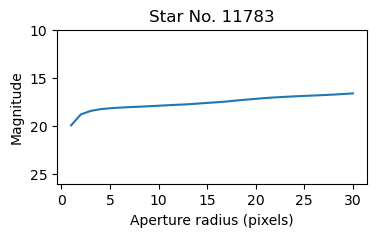

Keep? (yes/[n]o/quit) y


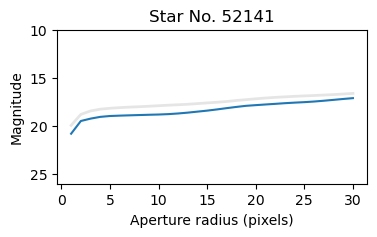

Stars selected: [11783]
19 more to go.


Keep? (yes/[n]o/quit) y


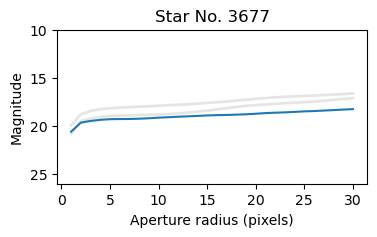

Stars selected: [11783, 52141]
18 more to go.


Keep? (yes/[n]o/quit) y


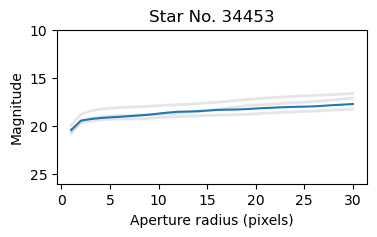

Stars selected: [11783, 52141, 3677]
17 more to go.


Keep? (yes/[n]o/quit) y


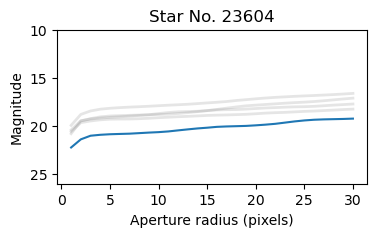

Stars selected: [11783, 52141, 3677, 34453]
16 more to go.


Keep? (yes/[n]o/quit) y


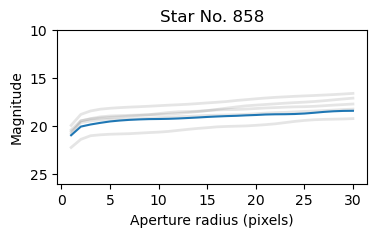

Stars selected: [11783, 52141, 3677, 34453, 23604]
15 more to go.


Keep? (yes/[n]o/quit) y


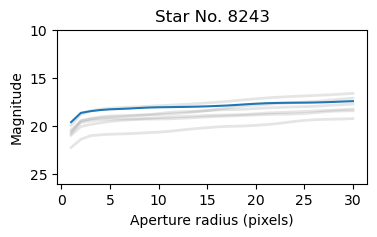

Stars selected: [11783, 52141, 3677, 34453, 23604, 858]
14 more to go.


Keep? (yes/[n]o/quit) y


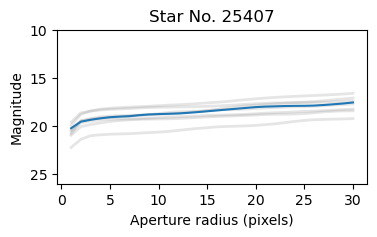

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243]
13 more to go.


Keep? (yes/[n]o/quit) y


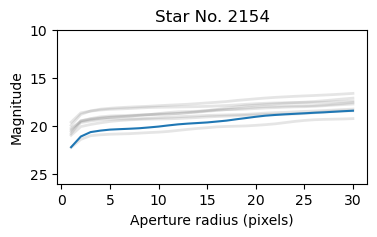

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407]
12 more to go.


Keep? (yes/[n]o/quit) y


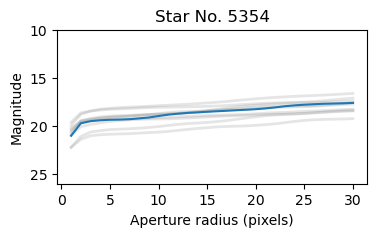

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154]
11 more to go.


Keep? (yes/[n]o/quit) y


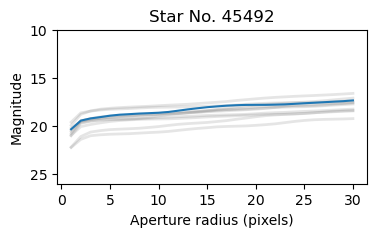

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354]
10 more to go.


Keep? (yes/[n]o/quit) y


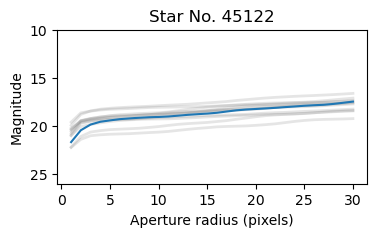

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492]
9 more to go.


Keep? (yes/[n]o/quit) y


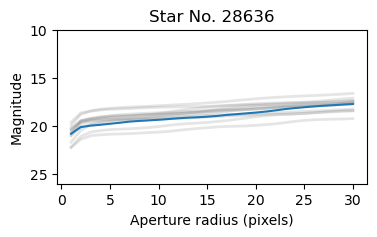

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122]
8 more to go.


Keep? (yes/[n]o/quit) y


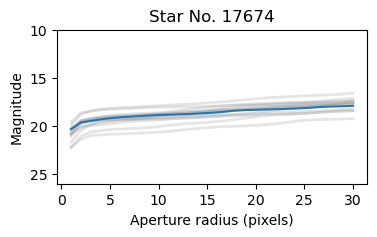

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636]
7 more to go.


Keep? (yes/[n]o/quit) y


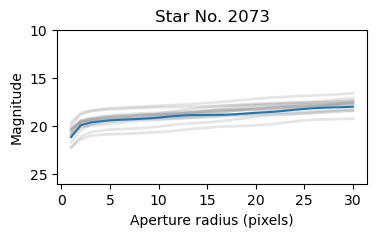

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674]
6 more to go.


Keep? (yes/[n]o/quit) y


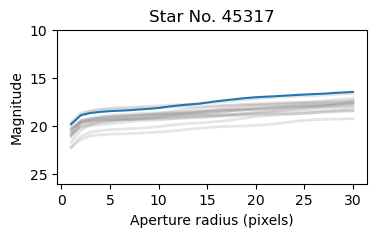

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674, 2073]
5 more to go.


Keep? (yes/[n]o/quit) y


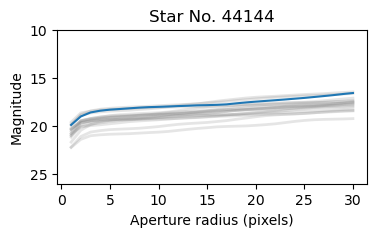

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674, 2073, 45317]
4 more to go.


Keep? (yes/[n]o/quit) y


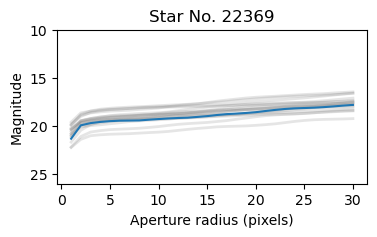

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674, 2073, 45317, 44144]
3 more to go.


Keep? (yes/[n]o/quit) y


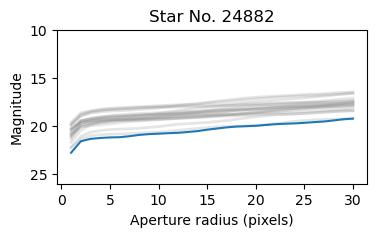

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674, 2073, 45317, 44144, 22369]
2 more to go.


Keep? (yes/[n]o/quit) y


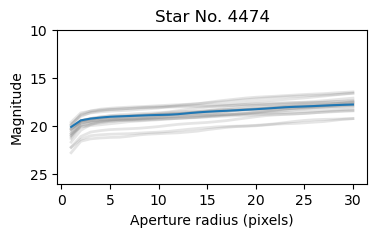

Stars selected: [11783, 52141, 3677, 34453, 23604, 858, 8243, 25407, 2154, 5354, 45492, 45122, 28636, 17674, 2073, 45317, 44144, 22369, 24882]
1 more to go.


Keep? (yes/[n]o/quit) y


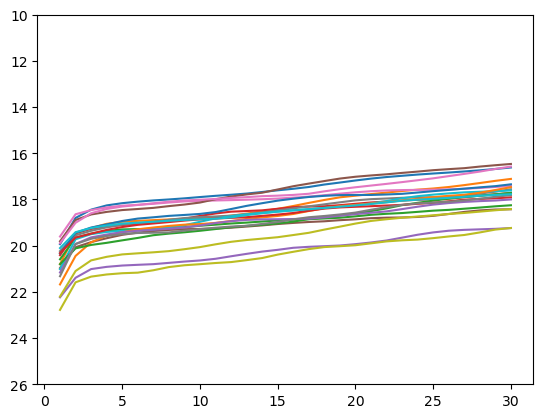

Check all profiles and enter 'y' to continue calculation:  y


-1.2853413910958322 0.24769123017595693 -0.7937041283676562 0.20082203694373496


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.psf import fit_fwhm   
from photutils.background import Background2D, MedianBackground
from photutils.aperture import CircularAperture, aperture_photometry

from perform_photometry import find_objects

from XRBID.AutoPhots import SubtractBKG, CorrectAp

import time

import os 
cd = os.chdir

long_filter = ["F070W", "F090W", "F115W", "F140M",
                    "F150W2", "F150W", "F162M", "F164N",
                    "F182M", "F187N", "F200W", "F210M",
                    "F212N", "F250M", "F277W", "F300M",
                    "F322W2", "F323N", "F335M", "F356W",
                    "F360M", "F405N", "F410M", "F430M",
                    "F444W", "F460M", "F466N", "F470N"
                    "F480M"]

short_filter = ["F070W", "F090W", "F115W", "F140M",
                "F150W2", "F150W", "F162M", "F164N",
                "F182M", "F187N", "F200W", "F210M",
                "F212N"]

'''
1. DAOFind to identify stars [done]
2. Generate background subtracted hdu image
3. Run Photometry using the background-subtracted image.  
        - full aperture photometry between 1-30 pixels radii
        - aperture photometry within 3 pixels 
        - aperture photometry within the extended radius for clusters 
4. Aperture correction on full aperture photometry. Apply correction
    to both the minimum aperture photometry and the extended aperture photometry 
'''

jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"

# find objects in the image
data = fits.getdata(f200w)
# data = data[3200:3400, 3600:3800]
objects = find_objects(data, fwhm=0.17, vmax=10, plot=False)

print("Object Identification worked")

# Background subtraction
data_sub = SubtractBKG(data)
print("Background Subtracted")
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))
print("Background substraction worked")

# Create Apertures
def create_apertures(positions, rad_list=(1, 31)):
    ap_rads = [i for i in range(1,31)]
    apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
    apertures_source = CircularAperture(positions, r=3) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=10) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended

apertures_full, apertures_sources, apertures_extended = create_apertures(positions)

print("Aperture creation worked...")

print("Starting Photometry...")
gal = "M66"
instrument = "nircam"
suffix = ''
filter = 'f200w'

def perform_photometry(data_sub, apertures, type, savefile=True):
    '''
    A helper function to calculate the aperture photometry.
    type : full/extended/sources
    '''
    starttime = time.time()
    photometry = aperture_photometry(data_sub, apertures, method='center')
    endtime = time.time()
    photometry.write("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", overwrite=True)
    print("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", "saved")
    return photometry

cd(jwstdir)
phot_full = perform_photometry(data_sub, apertures_full, type='full')
phot_sources = perform_photometry(data_sub, apertures_sources, type='sources')
phot_extended = perform_photometry(data_sub, apertures_extended, type='extended')
print("Aperture Photometry worked")

# Aperture Corrections
cd("/Users/undergradstudent/Research/XRB-Analysis/Notebooks")
short_EEFs = pd.read_csv('Encircled_Energy_SW_ETCv2.csv')
long_EEFs = pd.read_csv('Encircled_Energy_LW_ETCv2.csv')
# Use 20 pixels: 0.6'' for short wavelength and 1.6'' for long wavelength for  as the default
def my_EEF(filter):
    if filter in short_filter:
        return long_EEFs.at[14, filter]
    if filter in long_filter:
        return long_EEFs.at[19, filter]
    
filter = "F200W"
EEF = my_EEF(filter)
print("Aperture corrections...")


print("Aperture corrections...")
min_rad = 3
max_rad = 20
extended_rad = 10 
num_stars = 20
ap_rads = [i for i in range(1,31)]
zmag = np.mean([25.55, 25.56, 25.60, 25.66])
apcorrections = CorrectAp(phot_full, radii=ap_rads, EEF=EEF, num_stars=num_stars, zmag=zmag, \
                        min_rad=min_rad, max_rad=max_rad, extended_rad=extended_rad)
if len(apcorrections) > 0:
    apcorr = apcorrections[0]
    aperr = apcorrections[1]
    apcorr_ext = apcorrections[2]
    aperr_ext = apcorrections[3]
else: 
    apcorr = 0
    aperr = 0

print(apcorr, aperr, apcorr_ext, aperr_ext)

In [ ]:
    apcorr_ext = 0
    aperr_ext = 0

print(apcorr, aperr, apcorr_ext, aperr_ext)

In [5]:
from XRBID.AutoPhots import SubtractBKG
data = fits.getdata(f200w)
data_sub = SubtractBKG(data)

In [9]:
type(data_sub)

numpy.ndarray

In [22]:
instrument = 'nircam'
def what_instrument(instrument):
    if instrument.lower() == 'acs' or 'wfc3':
        print("I am using HST")
    if instrument.lower() == 'nircam':
        print("I am using JWST")
        
what_instrument(instrument)

I am using HST
I am using JWST
